# Predicting Home Values
---
Sophia Stewart

December 13, 2021


## Overview

With this project, my goal is to find drivers of tax assessed property value so that I can improve our current model for predicting home values. By doing so, we can give better Zestimates and become a stronger contender in the home-buying business.

In [1]:
# import modules
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
import wrangle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import pearsonr, spearmanr
import scipy.stats as stats
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# turn off pink warnings
import warnings
warnings.filterwarnings('ignore')

## Data Preparation

To prepare the data I retrieved from the zillow database, I renamed columns for clarity, removed outliers, split the data into three samples to avoid overfitting, and standard-scaled continuous data for modeling. I also added a column to show where each property is located.

In [2]:
# list columns for outlier removal
out_cols = ['beds', 'baths', 'sq_ft', 'tax_value']
# list columns for scaling
scaled_cols = ['beds', 'baths', 'sq_ft']
# wrangle data
train, validate, test = wrangle.wrangle_zillow(out_cols, 1.5, scaled_cols)

## Data Exploration

To get some context going into data analysis, I first want to look at the distributions of 
individual variables:

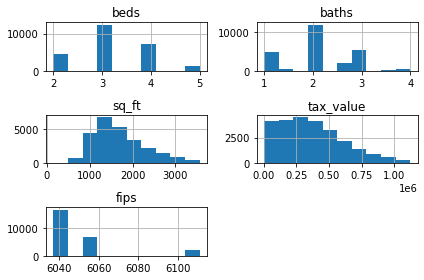

In [3]:
# list unscaled columns for visualization
unscaled_cols = ['beds', 'baths', 'sq_ft', 'tax_value', 'fips']
# visualize distributions of individual features
train[unscaled_cols].hist()
plt.tight_layout()

### Question 1: Does a home's location affect how much it costs?

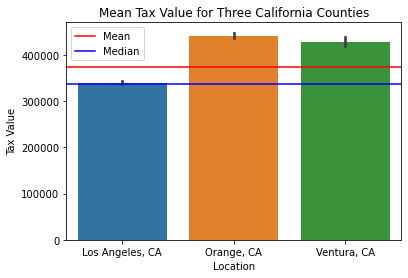

In [4]:
# plot mean tax_value by location
sns.barplot(data=train, x='fips_loc', y='tax_value')
plt.axhline(y=train.tax_value.mean(), color='r', label='Mean')
plt.axhline(y=train.tax_value.median(), color='b', label='Median')
plt.title('Mean Tax Value for Three California Counties')
plt.xlabel('Location')
plt.ylabel('Tax Value')
plt.legend();

In [5]:
# separate location's tax_value observations into individual series
la_value = train[train.fips_loc == 'Los Angeles, CA'].tax_value
# isolate tax values of properties not in los angeles
non_la_value = train[train.fips_loc != 'Los Angeles, CA'].tax_value
# set alpha
alpha = 0.05
# run t-test
t, p = stats.ttest_ind(la_value, non_la_value, equal_var=False)
# print results
if p < alpha:
    print('There is a difference')
else:
    print('There is no difference')
t, p

There is a difference


(-31.007191968235666, 1.2367728611954127e-205)

Just to be sure this was true across all counties, I ran this test for all three counties in our data and got similar results.

### Answer 1: Yes, there is a difference in property tax value depending on where the home is located.

### Question 2: Is there a relationship between number of bedrooms and number of bathrooms?

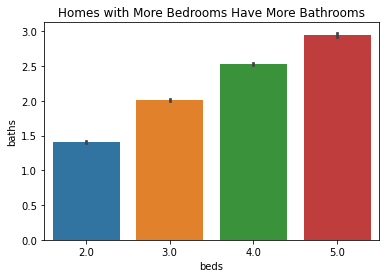

In [6]:
# view barplot of beds vs baths
sns.barplot(data=train, x='beds', y='baths')
plt.title('Homes with More Bedrooms Have More Bathrooms');

### Answer 2: Yes, there is a relationship between number of bedrooms and number of bathrooms.

### Question 3: Do bigger homes have more bathrooms?

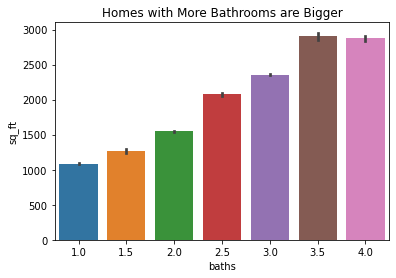

In [7]:
# barplot home size vs bathrooms
sns.barplot(data=train, y='sq_ft', x='baths')
plt.title('Homes with More Bathrooms are Bigger');

### Answer 3: Yes, bigger homes tend to have more bathrooms.

### Question 4: What drives tax_value?

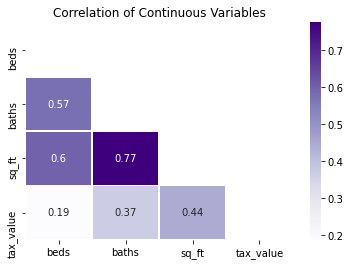

In [8]:
# plot heatmap to show correlation of continuous vars
zillow_corr = train[out_cols].corr()
sns.heatmap(zillow_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))
plt.title('Correlation of Continuous Variables');

In [9]:
# calculate corr, p-value using correlation test
corr, p = stats.pearsonr(train.sq_ft, train.tax_value)
# print results
if p < alpha:
    print('There is a linear relationship')
else:
    print('There is no linear relationship')
corr, p

There is a linear relationship


(0.4439850137758975, 0.0)

### Answer 4:  `sq_ft` is the biggest driver of `tax_value`.

### Data Exploration Summary
- `sq_ft` appears to be the strongest driver of `tax_value`
- On average, more bedrooms means more bathrooms
- Bigger houses have more bathrooms
- Although `fips` does seem to have an effect on `tax_value`, it does not appear to be significant enough to include in the modeling stage at this time.
- I will use `sq_ft`, `beds`, and `baths` to create my models.

---

## Modeling

To prepare the data for modeling, I listed the columns of scaled data I will be using in the models and split the three samples into x and y dataframes.

In [10]:
# separate samples into x and y
scaled_cols = ['beds_scaled', 'baths_scaled', 'sq_ft_scaled']

x_train = train[scaled_cols]
y_train = train.tax_value

x_validate = validate[scaled_cols]
y_validate = validate.tax_value

x_test = test[scaled_cols]
y_test = test.tax_value


y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

### Baseline

In [11]:
# establish baseline
baseline = baseline = train.tax_value.mean()
y_train['baseline'] = baseline
y_validate['baseline'] = baseline

# evaluate baseline on train and validate
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline)**0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline)**0.5

print('Baseline(mean `tax_value`) RMSE')
print(f'Train: {rmse_train}')
print(f'Validate: {rmse_validate}')

Baseline(mean `tax_value`) RMSE
Train: 244969.44100949066
Validate: 244786.9506494297


### Model 1: Ordinary Least Squares

In [12]:
# create object
lm = LinearRegression(normalize=True)
# fit model to train
lm.fit(x_train, y_train.tax_value)
# train predictions
y_train['ols_pred'] = lm.predict(x_train)
# evaluate model on train
rmse_train_ols = mean_squared_error(y_train.tax_value, y_train.ols_pred)**0.5
# validate predictions
y_validate['ols_pred'] = lm.predict(x_validate)
# evaluate model on validate
rmse_validate_ols = mean_squared_error(y_validate.tax_value, y_validate.ols_pred)**0.5

# print results
print(f'OLS RMSE Train: {rmse_train_ols}')
print(f'OLS RMSE Validate: {rmse_validate_ols}')

OLS RMSE Train: 217613.08303855872
OLS RMSE Validate: 216699.00485652036


### Model 2: LassoLars

In [13]:
# create object
lars = LassoLars()
# fit model to train
lars.fit(x_train, y_train.tax_value)
# make predictions on train
y_train['ll_pred'] = lars.predict(x_train)
# evaluate model on train
rmse_train_ll = mean_squared_error(y_train.tax_value, y_train.ll_pred)**0.5
# validate predictions
y_validate['ll_pred'] = lars.predict(x_validate)
# evaluate model on validate
rmse_validate_ll = mean_squared_error(y_validate.tax_value, y_validate.ll_pred)**0.5

# print results
print(f'LassoLars RMSE Train: {rmse_train_ll}')
print(f'LassoLars RMSE Validate: {rmse_validate_ll}')

LassoLars RMSE Train: 217613.41467660828
LassoLars RMSE Validate: 216689.23021125476


### Model 3: Polynomial Regression

In [14]:
# create polynomial features object
poly_feat = PolynomialFeatures()
# fit/transform object on train
x_train_poly = poly_feat.fit_transform(x_train)
# transform on validate and test
x_validate_poly = poly_feat.transform(x_validate)
x_test_poly = poly_feat.transform(x_test)
# create model object
plm = LinearRegression(normalize=True)
# fit model to train
plm.fit(x_train_poly, y_train.tax_value)
# make predictions on train
y_train['poly_pred'] = plm.predict(x_train_poly)
# evaluate model on train
rmse_train_poly = mean_squared_error(y_train.tax_value, y_train.poly_pred)**0.5
# validate predictions
y_validate['poly_pred'] = plm.predict(x_validate_poly)
# evaluate model on validate
rmse_validate_poly = mean_squared_error(y_validate.tax_value, y_validate.poly_pred)**0.5

# print results
print(f'Polynomial Regression RMSE Train: {rmse_train_poly}')
print(f'Polynomial Regression RMSE Validate: {rmse_validate_poly}')

Polynomial Regression RMSE Train: 217533.63421490567
Polynomial Regression RMSE Validate: 216584.59703183424


In [15]:
# view results as dataframe
rmse = pd.DataFrame({'Linear Regression':[rmse_train_ols, rmse_validate_ols, (rmse_train_ols-rmse_validate_ols)],
                    'LassoLars':[rmse_train_ll, rmse_validate_ll, (rmse_train_ll-rmse_validate_ll)],
                    'Polynomial':[rmse_train_poly, rmse_validate_poly, (rmse_train_poly-rmse_validate_poly)],
                    'Baseline':[rmse_train, rmse_validate, (rmse_train-rmse_validate)]},
                    index=['train', 'validate', 'difference'])
rmse

,Linear Regression,LassoLars,Polynomial,Baseline
train,217613.083039,217613.414677,217533.634215,244969.441009
validate,216699.004857,216689.230211,216584.597032,244786.950649
difference,914.078182,924.184465,949.037183,182.490360


Looking at these results, I conclude that the Polynomial Regression model is my best model. I will therefore now evaluate this model on the test sample.

In [16]:
# make y_test into dataframe
y_test = pd.DataFrame(y_test)
# evaluate baseline on test
y_test['baseline'] = baseline
rmse_test = mean_squared_error(y_test.tax_value, y_test.baseline)**0.5


# test predictions
y_test['poly_pred'] = plm.predict(x_test_poly)
# evaluate model on validate
rmse_test_poly = mean_squared_error(y_test.tax_value, y_test.poly_pred)**0.5
# print results
print(f'Baseline RMSE Test: {rmse_test}')
print(f'Polynomial Regression RMSE Test: {rmse_test_poly}')

Baseline RMSE Test: 243476.17293529224
Polynomial Regression RMSE Test: 217301.69629665604


---
## Conclusion

### Summary
There is absolutely room for improvement when it comes to our current model for predicting home values. By exploring the data we currently have, I was able to create a model with an RMSE value of 217301. While this is helpful, I know it can still be improved.

### Recommendation
Find a way to quantify subjective attributes of the home.
 - Nearby Attractions
 - Neighbor Quality
 - Neighborhood Safety

### Next Steps
With more time, I would like to dive deeper into the zillow database and implement feature engineering to discover the best combination of available features to predict home values. There is a ton of data in there and I'm sure we can use it to our advantage.


# Thank You!